<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and KNN - Train/Test Split

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Working with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?

**Be sure to provide interpretation for your results.**

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression Use Case

In this given task, you will be asked to model the median home price of various houses across U.S. Census tracts in the city of Boston. This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [4]:
import matplotlib.pyplot as plt

% matplotlib inline

In [5]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston

boston = load_boston()

X = pd.DataFrame(boston.data,
                 columns=boston.feature_names)
y = pd.DataFrame(boston.target,
                 columns=['MEDV'])

print(boston['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

### 1. Clean Up Data and Perform Exporatory Data Analysis

Boston data is from scikit-learn, so it ought to be pretty clean, but we should always perform exploratory data analysis.

In [6]:
# Exploratory data analysis.
# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
dtypes: float64(13)
memory usage: 51.5 KB


In [8]:
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [6]:
# There is NO null values in attributes or target column of 506 observations

In [9]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 1 columns):
MEDV    506 non-null float64
dtypes: float64(1)
memory usage: 4.0 KB


In [10]:
y.describe()

,MEDV
count,506.000000
mean,22.532806
std,9.197104
min,5.000000
25%,17.025000
50%,21.200000
75%,25.000000
max,50.000000


In [9]:
# All 13 attributes and 1 target are all float

In [11]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [12]:
y.describe()

,MEDV
count,506.000000
mean,22.532806
std,9.197104
min,5.000000
25%,17.025000
50%,21.200000
75%,25.000000
max,50.000000


In [13]:
X.nunique()

CRIM       504
ZN          26
INDUS       76
CHAS         2
NOX         81
RM         446
AGE        356
DIS        412
RAD          9
TAX         66
PTRATIO     46
B          357
LSTAT      455
dtype: int64

In [14]:
y.nunique()

MEDV    229
dtype: int64

In [25]:
data = pd.concat([X, y], axis=1)

## Using `scikit-learn` Linear Regression

### 2. Pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict our target variable, MEDV.
Score and plot your predictions. What do these results tell us?

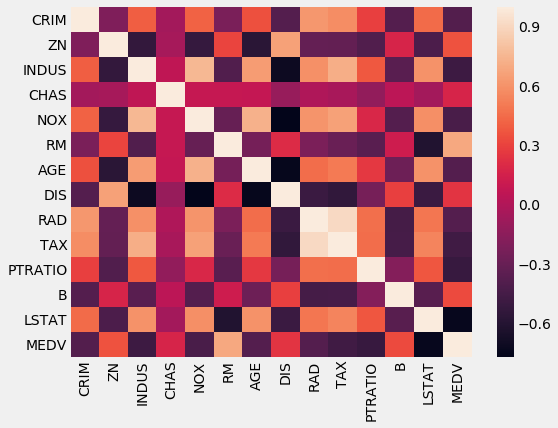

In [26]:
# Before choosing the predictors, plot a heatmap so as to see which features we can choose
import seaborn as sns
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14
plt.style.use("fivethirtyeight")

sns.heatmap(data.corr())

In [28]:
# pick 4 attributes columns that are most correlated to the the target values
#
features_cols = ['RM','PTRATIO','LSTAT','B']
X1=X[features_cols]
X1.head()

dataset = pd.concat([X1, y], axis=1)
dataset.head()

,RM,PTRATIO,LSTAT,B,MEDV
0,6.575,15.3,4.98,396.90,24.0
1,6.421,17.8,9.14,396.90,21.6
2,7.185,17.8,4.03,392.83,34.7
3,6.998,18.7,2.94,394.63,33.4
4,7.147,18.7,5.33,396.90,36.2


In [29]:
# linear regression Y against X1
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X1, y)

# Print the coefficients.
print(linreg.intercept_)
print(linreg.coef_)

[12.05477274]
[[ 4.74582604 -0.89903719 -0.51254309  0.0104569 ]]


In [30]:
#score the lr model, which returns the coefficient of determination R^2 of the prediction, best is 1
linreg.score(X1,y)

0.6877467603519637

In [31]:
# the R^ score is rather low, meaning teh actual y values is not very fitted in the linear regression model

In [33]:
#plot the errors of the predictions using the lr model
y_pred= linreg.predict(X1)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline



In [49]:
from sklearn import metrics
print(np.sqrt(metrics.mean_squared_error(y, y_pred)))

7.30131087747722


### 3. Try 70/30 and 90/10 train/test splits (70% of the data for training - 30% for testing, then 90% for training - 10% for testing)
Score and plot. How do your metrics change? What does this tell us about the size of training/testing splits?

In [59]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Define a function that accepts Xs and Y values, a parameter as a testing data set size (30% or 10%) and returns testing RMSE.
def train_test_rmse(Xs,Y, testsize):
    
    X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=testsize, random_state=123)
    
    #get lr model on training dataset
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    # get predicted y on x values from test set
    y_pred = linreg.predict(X_test)
    # get the RMSE from predicted y versus actual y in the testing set
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

# get the RMSE of 70/30 split
train_test_rmse(X1, y, 0.3)
# this is comparable to RMSE of model built and tested on the whole same dataset

7.430506469547107

In [42]:
train_test_rmse(X1, y, 0.1)

9.653297941287732

In [57]:
train_test_rmse(X1, y, 0.2)
# this is comparable to RMSE of model built and tested on the whole same dataset

7.464888618695281

In [54]:
train_test_rmse(X1, y, 0.15)

8.282096897701084

In [56]:
#RMSE increases with the decreasing size of the testing data set, which is expected as a smaller out -of-sample data pool 
#will have less chance of being fitted by the LR created from the training set
# We need to optimally choose the training/test split, choosing the size of testing not too small (10%), not too big(50%)

### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds?

In [60]:
from sklearn import model_selection

In [70]:
# define a function that takes Xsm y the number of fold in k-cross validation and return RMSE and R^2

def get_RMSE_R2_crossval(Xs, y, k):
    
    kf = model_selection.KFold(n_splits=k, shuffle=True)

    mse_values = []
    scores = []
    n = 0

    #print("~~~~ CROSS VALIDATION each fold ~~~~")
    for train_index, test_index in kf.split(Xs, y):
        lr = LinearRegression().fit(Xs.iloc[train_index], y.iloc[train_index])

        mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(Xs.iloc[test_index])))
        scores.append(lr.score(Xs, y))

        n += 1

        #print('Model {}'.format(n))
        #print('MSE: {}'.format(mse_values[n-1]))
        #print('R2: {}\n'.format(scores[n-1]))


    print("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
    print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
    print('Mean of R2 for all folds: {}'.format(np.mean(scores)))
    
get_RMSE_R2_crossval(X1, y, 5)

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 54.00769599293333
Mean of R2 for all folds: 0.3675630369437942


In [71]:
get_RMSE_R2_crossval(X1, y, 6)

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 54.28491710591583
Mean of R2 for all folds: 0.36747005018420786


In [74]:
get_RMSE_R2_crossval(X1, y, 7)

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 54.6365560831807
Mean of R2 for all folds: 0.3672666487332933


In [73]:
get_RMSE_R2_crossval(X1, y, 8)

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 54.78629402329062
Mean of R2 for all folds: 0.3672626331706358


In [72]:
get_RMSE_R2_crossval(X1, y, 9)

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 54.49180909445684
Mean of R2 for all folds: 0.36763693751157733


In [75]:
get_RMSE_R2_crossval(X1, y, 10)

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 54.42028250468529
Mean of R2 for all folds: 0.36789207763670817


In [79]:
get_RMSE_R2_crossval(X1, y, 2)

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 55.2604445862701
Mean of R2 for all folds: 0.36065794400911133


In [ ]:
# model evaluation metrics like RMSE and R2 do not differ much when we do 5-fold and any number of folds till 10

In [1]:
#note that the lower the K, the larger the testing size, outliers impact can ben evened out by non-outliers values more often,
#hence the RMSE is lower
# in short, the higher the k, the higher the RMSE

# KNN Practice

In [103]:
# Read the iris data into a DataFrame
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv(url, header=None, names=col_names)
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [104]:
# Increase the default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14

In [106]:
# Create a custom colormap
from matplotlib.colors import ListedColormap
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

In [ ]:
# Map each iris species to a number
# Let's use Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2 and create a column called 'species_num'

# Create a scatterplot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES

# Create a scatterplot of SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES


## KNN Classification of the Iris Dataset

### Create your feature matrix "X"
This will be all species measurements (sepal length, petal width, etc...)

In [113]:
features_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
X=iris[features_cols]
X.head(2)

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2


### Create your target vector "y"
This will be the species type.

In [117]:
y = iris['species']
y.head(2)

#label encode
from sklearn.preprocessing import LabelEncoder
#import numpy as np

le = LabelEncoder()
iris['species_num'] = le.fit_transform(iris['species'])
iris.head(3)

,sepal_length,sepal_width,petal_length,petal_width,species,species_num
0,5.1,3.5,1.4,0.2,Iris-setosa,0
1,4.9,3.0,1.4,0.2,Iris-setosa,0
2,4.7,3.2,1.3,0.2,Iris-setosa,0


### Make Use of Train-Test-Split
Split your data in to train and test sets.

In [136]:
from sklearn.model_selection import train_test_split

X = iris.drop(['species','species_num'], axis = 1)
y = iris['species_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### Import KNN From `scikit-learn` and Instatiate a Model With One Neighbor

In [137]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

knn = KNeighborsClassifier(n_neighbors=1) #instantiate a model with one neighbor
knn.fit(X_train, y_train) #fit

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

### Check the Accuracy
Train your model using the training set then use the test set to determine the accuracy

In [138]:
y_pred_class = knn.predict(X_test)

print((metrics.accuracy_score(y_test, y_pred_class)))

1.0


### Create a Model With Five Neighbors. Did it Improve?

In [139]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)
print((metrics.accuracy_score(y_test, y_pred_class))) # k=50 is not much better either

0.8666666666666667


### Create a Looped Function That Will Check All Levels of Various Neighbors and Calculate the Accuracy

In [154]:
for k in range(1,51):     
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_class = knn.predict(X_test)
    
    print ('k =',k)
    print('Accuracy score of KNN model =',(metrics.accuracy_score(y_test, y_pred_class)))

k = 1
Accuracy score of KNN model = 1.0
k = 2
Accuracy score of KNN model = 0.9666666666666667
k = 3
Accuracy score of KNN model = 0.9666666666666667
k = 4
Accuracy score of KNN model = 1.0
k = 5
Accuracy score of KNN model = 0.9666666666666667
k = 6
Accuracy score of KNN model = 1.0
k = 7
Accuracy score of KNN model = 1.0
k = 8
Accuracy score of KNN model = 1.0
k = 9
Accuracy score of KNN model = 1.0
k = 10
Accuracy score of KNN model = 1.0
k = 11
Accuracy score of KNN model = 1.0
k = 12
Accuracy score of KNN model = 1.0
k = 13
Accuracy score of KNN model = 1.0
k = 14
Accuracy score of KNN model = 1.0
k = 15
Accuracy score of KNN model = 1.0
k = 16
Accuracy score of KNN model = 1.0
k = 17
Accuracy score of KNN model = 1.0
k = 18
Accuracy score of KNN model = 1.0
k = 19
Accuracy score of KNN model = 1.0
k = 20
Accuracy score of KNN model = 1.0
k = 21
Accuracy score of KNN model = 1.0
k = 22
Accuracy score of KNN model = 1.0
k = 23
Accuracy score of KNN model = 1.0
k = 24
Accuracy score

### Bonus: According to `scikit-learn` Documentation, What is `knn.predict_proba(X_new)` Going to Do?

## Enrichment
_Everything beyond this point is enrichment and examples using Statsmodels for linear regression._

### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.

In [ ]:
# First, format our data in a DataFrame

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

In [ ]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf

# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX"
}

model = smf.ols(formula=formulas['case1'], data=df)
result = model.fit()

result.summary()

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

### Bonus Challenge #2:

Given a combination of predictors, can you find another response variable that can be accurately predicted through the exploration of different predictors in this data set?

_Tip: Check out pairplots, coefficients, and Pearson scores._

In [ ]:
# Check out variable relations
import seaborn as sns

sns.pairplot(X);

In [ ]:
# Check out Pearson scores


## Demo: Patsy

In [ ]:
import patsy

# Add response to the core DataFrame
df['MEDV'] = y

In [ ]:
from sklearn.model_selection import train_test_split #If you didn't import it earlier, do so now

# Easily change your variable predictors without reslicing your DataFrame
y, X = patsy.dmatrices("MEDV ~ AGE + RM", data=df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)


In [ ]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Rerun your model, iteratively changing your variables and train_size from the previous cell

lm = LinearRegression()
model = lm.fit(X_train, y_train)

predictions = model.predict(X_test)
print("R^2 Score: {}".format(metrics.r2_score(y_test, predictions)))